# **FINE-TUNING DE UN MODELO PARA ANÁLISIS DE SENTIMIENTO**

En esta notebook nos centraremos en fine-tunear [DistilBERT](https://huggingface.co/distilbert/distilbert-base-uncased) para una tarea de clasificación de texto binaria: análisis de sentimiento.

La tarea de **análisis de sentimiento** consiste en determinar la emoción expresada en un texto. Intenta contestar la pregunta siguiente: "¿El texto es positivo o negativo?".



## **0.0. Comprobación del entorno de Google Colab**
Necesitamos comprobar que usamos un entorno que disponga de una GPU. Google Colab nos ofrece de manera gratuita una Nvidia Tesla T4. Podemos comprobar con el siguiente comando si nuesto entorno de ejecución puede haciendo uso de la GPU.


In [ ]:
!nvidia-smi


Thu Apr 24 10:37:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             18W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Deberías de estar viendo una salida como la siguiente:

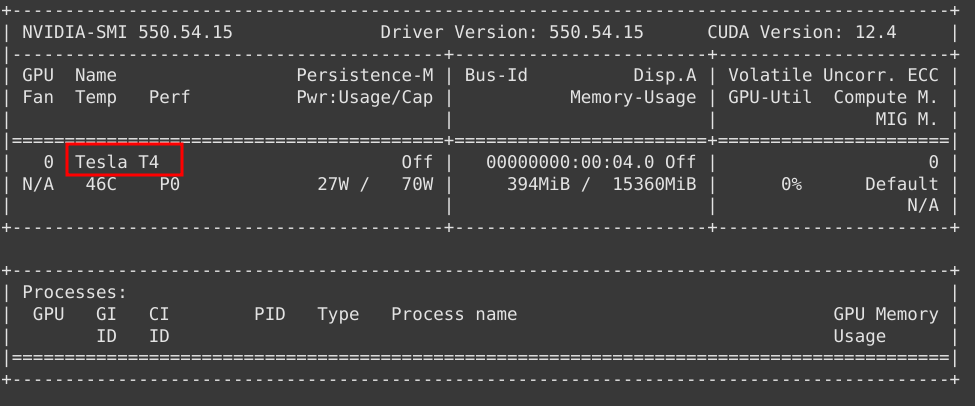

## **0.1. Instalación de librerías**

In [ ]:
!pip install datasets evaluate

In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset
from transformers import pipeline
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

## **1. Carga del dataset**

In [ ]:
imdb = load_dataset("imdb")

El dataset se divide principalmente en dos particiones:
- `train`: usada para el fine-tuning del modelo. El modelo aprende de estos datos.
- `test`: usada para evaluar el modelo para reportar resultados de la performance conseguida.

En el dataset, cada ejemplo tiene dos campos:

- `text`: la reseña de una película
- `label`: `0` para reseñas negativas y `1` para reseñas positivas

Este es un ejemplo:

In [ ]:
imdb["test"][100]

## **2. Preprocesado del dataset**

El preprocesado de los textos se lleva a cabo con el tokenizador del modelo.

#### **2.1. Carga del tokenizador del modelo que utilizaremos**

Hay varias reglas que pueden regir este proceso de tokenización: si usamos un modelo preentrenado, es importante usar el tokenizador preentrenado asociado. Este dividirá el texto que le des en tokens de la misma manera que se hizo con el corpus utilizado para el preentrenamiento, y usará la misma correspondencia entre tokens e índices (lo que normalmente llamamos un *vocabulario*) que durante el preentrenamiento del modelo.

In [ ]:
model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

#### **2.2. Ejemplo**

<font color="blue">Puedes escribir tu frase de ejemplo a continuación (en inglés):</font>

In [ ]:
sentence = ""

Cuando introducimos nuestra frase en el tokenizador, este dividirá el texto en palabras (o partes de palabras, símbolos de puntuación, etc.), llamados *tokens*.

In [ ]:
tokenizer.tokenize(sentence)

Luego, estos tokens se convierten en números para poder construir un tensor a partir de ellos y pasárselo al modelo.

Esto nos dará:

- `input_ids`: los índices que corresponden a cada token de nuestra frase.
- `attention_mask`: indica a qué tokens debe prestar atención el modelo y a cuáles no.

In [ ]:
tokenizer(sentence)

#### **2.3. Preprocesado del dataset**

Preprocesamos el `text` del dataset.


In [ ]:
# función para preprocesar el texto
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

Este sería el resultado del preprocesado del ejemplo de nuestro dataset:

In [ ]:
preprocess_function(imdb["test"][100])

Aplicamos la función a todo el dataset:

In [ ]:
tokenized_imdb = imdb.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## **3. Fine-tuning del modelo**


Puesto que queremos resolver un problema de clasificación **binaria**, la predicción del modelo será `0` o `1`. Necesitamos darle un nombre a cada una de estas dos predicciones. Decidimos asociar la predicción `0` como *negativo* y `1` como *positivo*.

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}


¡Ya podemos hacer el fine-tuning del modelo!

#### **3.1. Carga del modelo**
Cargamos el modelo y especificamos el número de labels, así como los diccionarios que nos permiten "traducir" de los números a las etiquetas, y viceversa.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=2,
                                                           id2label=id2label,
                                                           label2id=label2id
                                                           )

#### **3.2. Definición de los argumentos de entrenamiento**

Con el modelo cargado, configuramos los hiperparámetros de entrenamiento.

Los hiperparámetros son variables que controlan el proceso de entrenamiento —como la *learning rate*, el *batch size* o el número de *epochs*— y que influyen directamente en el rendimiento del modelo. Seleccionar los hiperparámetros adecuados es importante, y debemos experimentar con ellos para encontrar la mejor configuración para la tarea.

Puesto que solo estamos haciendo un pequeño fine-tuning de un modelo fundacional ya entrenado con muchos datos, solo tenemos que ajustarlo para que resuelva nuestra tarea de clasificación de reseñas.

In [ ]:
training_args = TrainingArguments(
    output_dir="distilbert_sentiment_analysis",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to=[],
    fp16=True,
    gradient_accumulation_steps=2,
)

#### **3.3. Definición de la métrica de evaluación**

Incluir una métrica durante el fine-tuning es necesario para poder evaluar si nuestro modelo funciona bien para nuestra tarea. En este caso, cargamos la métrica de *accuracy* (% de predicciones correctas con respecto al total).

In [ ]:
accuracy = evaluate.load("accuracy")

Luego, creamos una función para calcular la *accuracy* teniendo en cuenta las predicciones del modelo y las labels correctas (establecidas en el dataset).

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

#### **3.4. Fine-tuning del modelo**

Pasamos los argumentos de entrenamiento al `Trainer` junto con el modelo, el dataset, el tokenizador y la función de evaluación. Finalmente, iniciamos el fine-tuning.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

## **4. Inferencia**

Ahora que hemos hecho fine-tuning a un modelo, ¡ya podemos usarlo!

Cargamos el modelo que hemos entrenado:

In [ ]:
classifier = pipeline("sentiment-analysis", model="distilbert_sentiment_analysis/checkpoint-391")

Probamos con una frase del dataset:

In [ ]:
test_sentence = imdb['test'][899]
test_sentence

Comprobamos si la predicción del modelo encaja con la etiqueta correcta (establecida en el dataset):

In [ ]:
classifier(test_sentence['text'])

<font color="blue"> ¿Coinciden las etiquetas?</font>

 <font color="blue">Puedes probar con tus propios ejemplos. Escribe en inglés una reseña negativa o positiva. ¿El modelo clasifica bien tu opinión?</font>

In [ ]:
example = ""
classifier(example)

## **Referencias**

Esta notebook es una adaptación del [tutorial de clasificación de texto de Hugging Face](https://huggingface.co/docs/transformers/v4.51.3/tasks/sequence_classification).